In [110]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [111]:
def make_batch():
    onehot_vector = np.eye(n_class)
    
    input_batch = [onehot_vector[[word_to_idx[word] for word in sentences[0].split()]]]
    output_batch = [onehot_vector[[word_to_idx[word] for word in sentences[1].split()]]]
    target_batch = [[word_to_idx[word] for word in sentences[2].split()]]
    
    input_batch = torch.FloatTensor(input_batch)
    output_batch = torch.FloatTensor(output_batch)
    target_batch = torch.LongTensor(target_batch)
    
    return input_batch, output_batch, target_batch

In [112]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        
        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
        
        # Linear for Attention
        self.attn = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden * 2, n_class)
        
        
    def forward(self, enc_inputs, hidden, dec_inputs):
        enc_inputs = enc_inputs.transpose(0, 1) # (n_step, batch_size, n_class)
        dec_inputs = dec_inputs.transpose(0, 1) # (n_step, batch_size, n_class)
        
        enc_outputs, hidden = self.enc_cell(enc_inputs, hidden)
        # enc_outputs: (n_step, batch_size, n_hidden)
        # hidden: (1*1, batch_size, n_hidden)
        
        trained_attn = []
        n_step = len(dec_inputs)
        result = torch.empty([n_step, 1, n_class])
        
        for i in range(n_step):
            dec_output, hidden = self.dec_cell(dec_inputs[i].unsqueeze(0), hidden)
            # dec_output: (1, batch_size, n_hidden)
            # hidden: (1*1, batch_size, n_hidden)
            
            attn_weights = self.get_attn_weight(dec_output, enc_outputs) # (1, 1, n_step)
            trained_attn.append(attn_weights.squeeze().data.numpy())
            
            # bmm = batch matrix multiplication (matmul과 비슷)
            context_vector = attn_weights.bmm(enc_outputs.transpose(0, 1))
            # (1, 1, n_step) x (batch_size(=1), n_step, n_hidden) = (1, 1, n_hidden)
            
            dec_output = dec_output.squeeze(0) # (batch_size(=1), n_hidden)
            context_vector = context_vector.squeeze(1) # (1, n_hidden)
            
            concat = torch.cat((dec_output, context_vector), 1) # (1, n_hidden * 2)
            result[i] = self.out(concat) # (1, n_class)
            
        return result.transpose(0, 1).squeeze(0), trained_attn # (n_step, n_class), (1, n_step, n_step)
            
        
    def get_attn_weight(self, dec_output, enc_outputs):
        # get attention weight of one 'dec_output' with 'enc_outputs'
        n_step = len(enc_outputs)
        attn_scores = torch.zeros(n_step)
        
        for i in range(n_step):
            attn_scores[i] = self.get_attn_score(dec_output, enc_outputs[i])
        
        return F.softmax(attn_scores, dim=0).view(1, 1, -1) # (1, 1, n_step)
        
            
    def get_attn_score(self, dec_output, enc_output):
        # dec_output: (1, batch_size, n_hidden)
        # enc_output: (batch_size, n_hidden)
        score = self.attn(enc_output) # (batch_size, n_hidden)
        return torch.dot(dec_output.view(-1), score.view(-1))

In [113]:
n_step = 5
n_hidden = 128

In [114]:
sentences = ["ich mochte ein bier P", "S i want a beer", "i want a beer E"]

word_list = list(set(" ".join(sentences).split()))
word_to_idx = {word: idx for idx, word in enumerate(word_list)}
idx_to_word = {idx: word for idx, word in enumerate(word_list)}
n_class = len(word_list)
batch_size = 1

In [115]:
model = Attention()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [116]:
input_batch, output_batch, target_batch = make_batch()

In [117]:
# Training
for epoch in range(1000):
    optimizer.zero_grad()
    
    hidden = torch.zeros([1*1, batch_size, n_hidden])
    output, _ = model(input_batch, hidden, output_batch) # (n_step, n_class)
    
    # target_batch: (1, n_step, n_class)
    loss = criterion(output, target_batch.squeeze(0))
    if (epoch + 1) % 100 == 0:
        print("Epoch : {:4d}  loss: {:.6f}".format(epoch + 1, loss))
        
    loss.backward()
    optimizer.step()

Epoch :  100  loss: 0.003183
Epoch :  200  loss: 0.001320
Epoch :  300  loss: 0.000731
Epoch :  400  loss: 0.000468
Epoch :  500  loss: 0.000327
Epoch :  600  loss: 0.000242
Epoch :  700  loss: 0.000186
Epoch :  800  loss: 0.000148
Epoch :  900  loss: 0.000120
Epoch : 1000  loss: 0.000100


In [118]:
# Test
onehot_vector = np.eye(n_class)
test_batch = [onehot_vector[[word_to_idx[word] for word in 'SPPPP']]]
test_batch = torch.FloatTensor(test_batch)
hidden = torch.zeros([1*1, batch_size, n_hidden])

predicts, trained_attn = model(input_batch, hidden, test_batch)
predicts = predicts.data.max(1, keepdim=True)[1]

print(sentences[0], '->', " ".join([idx_to_word[predict.item()] for predict in predicts.squeeze()]))

ich mochte ein bier P -> i want a beer E


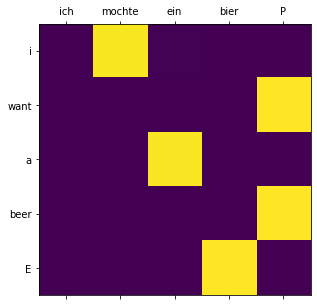

In [119]:
# Show Attention
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(trained_attn, cmap='viridis')
ax.set_xticks([0,1,2,3,4])
ax.set_yticks([0,1,2,3,4])
ax.set_xticklabels(sentences[0].split())
ax.set_yticklabels(sentences[2].split())
plt.show()